In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import anndata
import scvi
import scanpy as sc

from scipy.stats import spearmanr

from vaes import *

Global seed set to 0


https://docs.scvi-tools.org/en/stable/tutorials/notebooks/scarches_scvi_tools.html

In [2]:
ref_a= sc.read_h5ad('../data/scRNAseq-expts/pbmc_ref.h5ad')
scvi.data.setup_anndata(ref_a, 
                        batch_key='orig.ident', 
                        labels_key='celltype.l2')

INFO     Using batches from adata.obs["orig.ident"]                                          
INFO     Using labels from adata.obs["celltype.l2"]                                          
INFO     Using data from adata.X                                                             


/Users/igor/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function setup_anndata is deprecated; Please use the model-specific setup_anndata methods instead. The global method will be removed in version 0.15.0.
  warnings.warn(msg, category=FutureWarning)


INFO     Successfully registered anndata object containing 101089 cells, 2000 vars, 16       
         batches, 30 labels, and 0 proteins. Also registered 0 extra categorical covariates  
         and 0 extra continuous covariates.                                                  
INFO     Please do not further modify adata until model is trained.                          


In [3]:
# train
vae_ref = scvi.model.SCVI(ref_a,
                          use_layer_norm="both", 
                          use_batch_norm="none", 
                          encode_covariates=True,
                          dropout_rate=0.2, 
                          n_layers=2)
vae_ref.train(max_epochs=200)

vae_ref_scan = scvi.model.SCANVI.from_scvi_model(vae_ref, unlabeled_category='Unknown')
vae_ref_scan.train(max_epochs=20, n_samples_per_label=100)

dir_path_scan= '../data/scRNAseq-expts/scVI/pbmc2/'
vae_ref_scan.save(dir_path_scan, overwrite=True)

INFO     Using batches from adata.obs["orig.ident"]                                          
INFO     Using labels from adata.obs["celltype.l2"]                                          
INFO     Using data from adata.X                                                             


/Users/igor/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function setup_anndata is deprecated; Please use the model-specific setup_anndata methods instead. The global method will be removed in version 0.15.0.
  warnings.warn(msg, category=FutureWarning)


INFO     Successfully registered anndata object containing 101089 cells, 2000 vars, 16       
         batches, 30 labels, and 0 proteins. Also registered 0 extra categorical covariates  
         and 0 extra continuous covariates.                                                  
INFO     Please do not further modify adata until model is trained.                          


GPU available: False, used: False
TPU available: False, using: 0 TPU cores


Epoch 200/200: 100%|██████████| 200/200 [2:07:40<00:00, 38.30s/it, loss=751, v_num=1]  
INFO     Training for 20 epochs.                                                             


GPU available: False, used: False
TPU available: False, using: 0 TPU cores


Epoch 20/20: 100%|██████████| 20/20 [28:41<00:00, 86.08s/it, loss=876, v_num=1]


In [4]:
# evals
ref_v= sc.read_h5ad('../data/scRNAseq-expts/pbmc_query.h5ad')
dir_path_scan= '../data/scRNAseq-expts/scVI/pbmc2/'
vae_q = scvi.model.SCANVI.load_query_data(ref_v,dir_path_scan)
vae_q._unlabeled_indices = np.arange(ref_v.n_obs)
vae_q._labeled_indices = []

vae_q.train(max_epochs=100, plan_kwargs=dict(weight_decay=0.0), check_val_every_n_epoch=10)
ref_v.obs['preds_scanvi_pst']= vae_q.predict()
pst_smp= vae_q.posterior_predictive_sample(ref_v)


INFO     Using data from adata.X                                                             


/Users/igor/opt/anaconda3/lib/python3.8/site-packages/scvi/model/base/_archesmixin.py:95: UserWarning: Query integration should be performed using models trained with version >= 0.8
  warnings.warn(
/Users/igor/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function transfer_anndata_setup is deprecated; This method will be removed in 0.15.0. Please avoid building any new dependencies on it.
  warnings.warn(msg, category=FutureWarning)


INFO     Registered keys:['X', 'batch_indices', 'labels']                                    
INFO     Successfully registered anndata object containing 51005 cells, 2000 vars, 24        
         batches, 30 labels, and 0 proteins. Also registered 0 extra categorical covariates  
         and 0 extra continuous covariates.                                                  
INFO     Training for 100 epochs.                                                            


GPU available: False, used: False
TPU available: False, using: 0 TPU cores


Epoch 100/100: 100%|██████████| 100/100 [55:33<00:00, 33.33s/it, loss=883, v_num=1]


In [5]:
vae_q.save('../data/scRNAseq-expts/scVI/pbmc_annot_l2/', overwrite=True)

In [3]:
ref_v= sc.read_h5ad('../data/scRNAseq-expts/pbmc_query.h5ad')
vae_q= scvi.model.SCANVI.load('../data/scRNAseq-expts/scVI/pbmc_annot_l2/', ref_v)
ref_v.obs['preds_scanvi_pst']= vae_q.predict()
pst_smp= vae_q.get_normalized_expression(ref_v).values

INFO     Using data from adata.X                                                             


/Users/igor/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function transfer_anndata_setup is deprecated; This method will be removed in 0.15.0. Please avoid building any new dependencies on it.
  warnings.warn(msg, category=FutureWarning)


INFO     Registered keys:['X', 'batch_indices', 'labels']                                    
INFO     Successfully registered anndata object containing 51005 cells, 2000 vars, 24        
         batches, 30 labels, and 0 proteins. Also registered 0 extra categorical covariates  
         and 0 extra continuous covariates.                                                  


In [4]:
mdl= VAEGamma(ref_a, n_prj=18, probes_per_gene= 80, total_probes=5e4, lblwt=.5)
mdl.train(n_iter= 1500, n_btch=4)

  0%|          | 0/1500 [00:00<?, ?it/s]

/Users/igor/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/Users/igor/opt/anaconda3/lib/python3.8/site-packages/pyro/util.py:286: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'prx_reg'}
  warnings.warn(


0 | elbo: 2.14E+08 | prc: 0.03 | r2: 0.00
150 | elbo: 2.37E+07 | prc: 0.10 | r2: 0.05
300 | elbo: 6.39E+06 | prc: 0.58 | r2: 0.28
450 | elbo: 3.55E+06 | prc: 0.89 | r2: 0.78
600 | elbo: 2.80E+06 | prc: 0.93 | r2: 0.91
750 | elbo: 2.51E+06 | prc: 0.94 | r2: 0.94
900 | elbo: 2.47E+06 | prc: 0.95 | r2: 0.95
1050 | elbo: 2.47E+06 | prc: 0.96 | r2: 0.91
1200 | elbo: 2.42E+06 | prc: 0.96 | r2: 0.91
1350 | elbo: 2.44E+06 | prc: 0.96 | r2: 0.94


In [5]:
lbl_str= {s:l for (s,l),_ in ref_a.obs.groupby(['_scvi_labels', 'celltype.l2'])}
ref_v.obs['preds_npst']= [lbl_str[l] for l in mdl.get_assignment({'cts':torch.FloatTensor(ref_v.X.toarray()), 'lbl':None}).tolist()]

In [6]:
prc_tab= pd.concat([pd.DataFrame([['scanvi', g,(v['celltype.l2']==g).mean()] for g,v in ref_v.obs.groupby('preds_scanvi_pst')]), 
                    pd.DataFrame([['napset', g,(v['celltype.l2']==g).mean()] for g,v in ref_v.obs.groupby('preds_npst')])]).rename({0:'model',1:'cell',2:'precision'},axis=1)
rcl_tab= pd.concat([pd.DataFrame([['scanvi', g,(v.preds_scanvi_pst==g).mean()] for g,v in ref_v.obs.groupby('celltype.l2')]), 
                    pd.DataFrame([['napset', g,(v.preds_npst==g).mean()] for g,v in ref_v.obs.groupby('celltype.l2')])]).rename({0:'model',1:'cell',2:'recall'},axis=1)

In [7]:
pst_nps= mdl.get_means({'cts':torch.FloatTensor(ref_v.X.toarray()), 'lbl':None})

In [9]:
rc2= []
for g,v in ref_v.obs.reset_index().groupby('celltype.l2'):
    r_n= spearmanr(ref_v[v.index].X.toarray().ravel(), 
                   pst_nps[v.index].detach().numpy().ravel())[0]
    r_s= spearmanr(ref_v[v.index].X.toarray().ravel(), 
                     pst_smp[v.index].ravel())[0]
    rc2.append((g, r_n, r_s))
rc2= pd.DataFrame(rc2, columns='celltype npst scvi'.split())

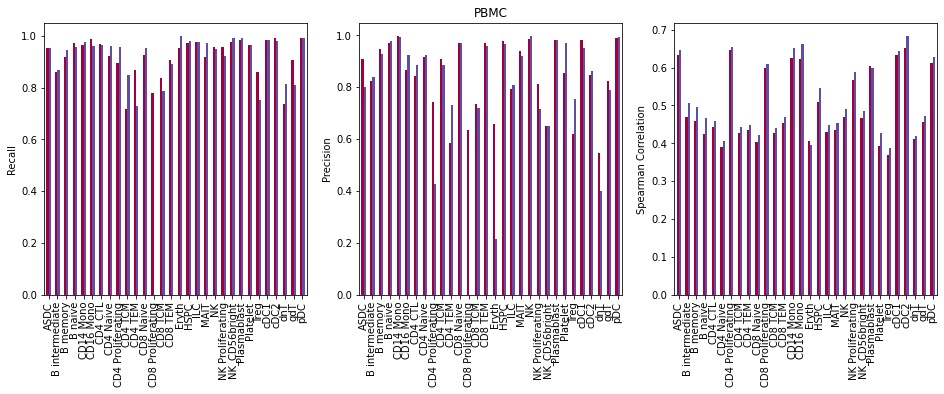

In [11]:
fig, axs= plt.subplots(ncols=3, figsize= (16,5))

rcl_tab.pivot('cell','model','recall').sort_index().plot(kind='bar', legend=False, colormap='Spectral', ax= axs[0])
axs[0].set_ylabel('Recall')
axs[0].set_xlabel('')

prc_tab.pivot('cell','model','precision').sort_index().plot(kind='bar', legend=False, colormap='Spectral', ax= axs[1])
axs[1].set_ylabel('Precision')
axs[1].set_xlabel('')
axs[1].set_title('PBMC')

rc2.set_index('celltype')[['npst', 'scvi']].plot(kind='bar', legend= False, colormap='Spectral', ax= axs[2])
axs[2].set_ylabel('Spearman Correlation')
axs[2].set_xlabel('')

fig.savefig('../rep/fig3_pbmc_comp.jpg')

In [23]:
recon_test.to_csv('../res/pbmc_l2_npst_recon.csv', index=False)
types_test.to_csv('../res/pbmc_l2_npst_types.csv', index=False)
recon_scanvi_pst.to_csv('../res/pbmc_l2_scvi_recon.csv', index=False)
types_scanvi_pst.to_csv('../res/pbmc_l2_scvi_types.csv', index=False)